In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
import matplotlib.colors as mcolors
import networkx as nx

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
rootpath = Path("../../")
basepath = Path("./")

In [4]:
runpath = rootpath / "paper" / "mouse_runs" / "runs"

In [5]:
treepath = rootpath / "data" / "mouse_experiments" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [6]:
outpath = basepath / "figs_mouse_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model

In [7]:
respath = get_min_loss_path(runpath, np.arange(10))

model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][10].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.l

0
1
2
3
4
5
6
7
8
9
4


C:\Users\Gary\AppData\Local\Temp\ipykernel_40784\1797940387.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(respath / MODEL_FILE)


In [8]:
taxonomy = apply_taxonomy_threshold(taxonomy)

# do beforehand..
name_updates = {'Otu10': {'Species': 'Faecalibaculum rodentium'},
'Otu17': {'Genus': 'Roseburia'},
'Otu6': {'Species': 'Eubacterium coprostanoligenes'},
'Otu20': {'Species': 'Muribaculum gordoncarteri'},
'Otu15': {'Genus': 'Eisenbergiella'},
'Otu43': {'Family': 'Lachnospiraceae'}}

taxonomy['Species'] = 'na'
for oidx in name_updates.keys():
    replace = name_updates[oidx]
    key = list(replace.keys())[0]
    newname = replace[key]
    taxonomy.loc[oidx,key] = newname

# Get summary results

In [9]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

# Make figure

### to do: final criteria for what to include

In [10]:
# dict of diets and times
diet_times = {'STD': [10,35,57,76],
'HF': [18],
'HFHF': [43],
'LP': [65]}

In [11]:
def average_diet_times(df, diet_times):
    df2 = df.copy()
    diets_keep = list(diet_times.keys())
    for k in diets_keep:
        df2[k] = df.loc[:,diet_times[k]].mean(axis=1)
    df2 = df2[diets_keep]
    return df2

# TO do: get colormap from data fig...

In [12]:
# def get key focus taxa...
taxa_foci = ['Otu2', 'Otu6']
otu_threshold = 0.05

colors = np.concatenate([sns.color_palette('muted', n_colors=10), sns.color_palette("dark", n_colors=10)])
familycolors = {x:y for x,y in zip(taxonomy['Family'].unique(),colors)}

avebeta = vis.get_subj_averaged_assemblage_proportions(betadf)
radf = vis.get_relative_abundances(data, times, subjects, taxonomy)

edge_weights = {}
node_weights = {}
pcolors = {}
for otuf in taxa_foci:
    assemblages = vis.get_assemblages_containing_taxon(thetadf, otuf)
    otus = vis.get_taxa_in_assemblages(thetadf, assemblages)
    
    edge_weights_temp = vis.get_edge_weights(thetadf, avebeta, assemblages, otuf, otus)
    ratemp = radf.loc[edge_weights_temp.index,:]
    node_weights[otuf] = average_diet_times(ratemp, diet_times)
    edge_weights[otuf] = average_diet_times(edge_weights_temp, diet_times)
    
    ncolors = {}
    for oidx in edge_weights_temp.index:
        fam = taxonomy.loc[oidx,'Family']
#         print(oidx, fam)
        ncolors[oidx] = familycolors[fam]
    pcolors[otuf] = ncolors

In [13]:
edge_threshold = 0.02
print(edge_weights['Otu2'].index[(edge_weights['Otu2']>edge_threshold).any(axis=1)])

Index(['Otu67', 'Otu1', 'Otu7', 'Otu41', 'Otu20', 'Otu2', 'Otu29', 'Otu6'], dtype='object', name='Otu')


In [14]:
def plot_association_changes(axs, edge_weights, node_weights, otu_focus, taxonomy,
                             node_colors=None, edge_scale=20, node_scale=2000, rad=1, textsize=12,
                            edge_threshold=0.02, edge_base=0):
    
    # subset over taxa that exceed edge_threshold on some diet
    
#     taxa = edge_weights.index
    taxa = edge_weights.index[(edge_weights>edge_threshold).any(axis=1)]
#     print(edge_weights)
#     print(taxa)
    diets = edge_weights.columns

    # make graph
    graph = nx.Graph()
    # add nodes and edges with default weights
    for oidx in taxa:
        if oidx != otu_focus:
            graph.add_edge(oidx, otu_focus, weight=1)
        graph.nodes[oidx]['weight'] = 500

    # get node positions
    pos = nx.spring_layout(graph)

    notus = len(taxa)
    xpos =  np.cos(np.linspace(0,1,notus)*2*np.pi)
    ypos =  np.sin(np.linspace(0,1,notus)*2*np.pi)
    i = 0
    for oidx in taxa:
        if oidx != otu_focus:
            pos[oidx] = np.array([xpos[i],ypos[i]])
            i += 1
        else:
            pos[oidx] = np.array([0,0])

    for i,diet in enumerate(diets):
        # update edge weights
        for oidx in taxa:
            if oidx != otu_focus:
                if edge_weights.loc[oidx,diet] >= edge_threshold:
                    graph[oidx][otu_focus]['weight'] = edge_scale*edge_weights.loc[oidx,diet] + edge_base
                else:
                    graph[oidx][otu_focus]['weight'] = 0
            # update node sizes
            graph.nodes[oidx]['weight']=node_scale*node_weights.loc[oidx,diet]

        # get node colors
        color_map = []
        for node in graph:
            if node_colors is not None:
                color_map.append(node_colors[node])
            else:
                color_map.append('tab:blue')

        # draw network
        ew = list(nx.get_edge_attributes(graph,'weight').values())
        nw = list(nx.get_node_attributes(graph,'weight').values())
        nx.draw_networkx(graph, pos=pos, ax=axs[i], width=ew, node_size=nw, 
                         node_color=color_map, with_labels=False, alpha=0.2)
        

        # annotate nodes
        for k in pos.keys():
            x = pos[k][0]
            y = pos[k][1]
            style = 'normal'
            if i == 0:
                s, level = vis.get_lowest_level(k, taxonomy)
                if (level == 'Genus') or (level == 'Species'):
                    style = 'italic'
                if level == 'Species':
                    genus, species = s.split(' ')
                    s = f'{genus[0]}. {species}'
                if k == otu_focus:
#                     s = taxonomy.loc[k,'Genus']
                    axs[i].text(x, y + 0.15 ,s=s, horizontalalignment='center', verticalalignment='center', fontsize=textsize, fontstyle=style)
                else:
#                     s = taxonomy.loc[k,'Genus'] # use lowest level instead...; italicize below family
                    # center those closest to zero...
                    if np.abs(x) < 0.2:
                        axs[i].text(x, 1.15*y + np.sign(y)*0.1 ,s=s, horizontalalignment='center', verticalalignment='center', 
                                    fontsize=textsize, fontstyle=style)
                    elif x > 0:
                        axs[i].text(x+0.1, 1.15*y ,s=s, horizontalalignment='left', verticalalignment='center', 
                                    fontsize=textsize, fontstyle=style)
                    else:
                        axs[i].text(x-0.1, 1.15*y ,s=s, horizontalalignment='right', verticalalignment='center', 
                                    fontsize=textsize, fontstyle=style)

            s = f'{k}'
            s = s[(s.find('u')+1):]
            axs[i].text(x, y ,s=s, horizontalalignment='center', verticalalignment='center', fontsize=textsize)
                    
                    
    return axs, graph

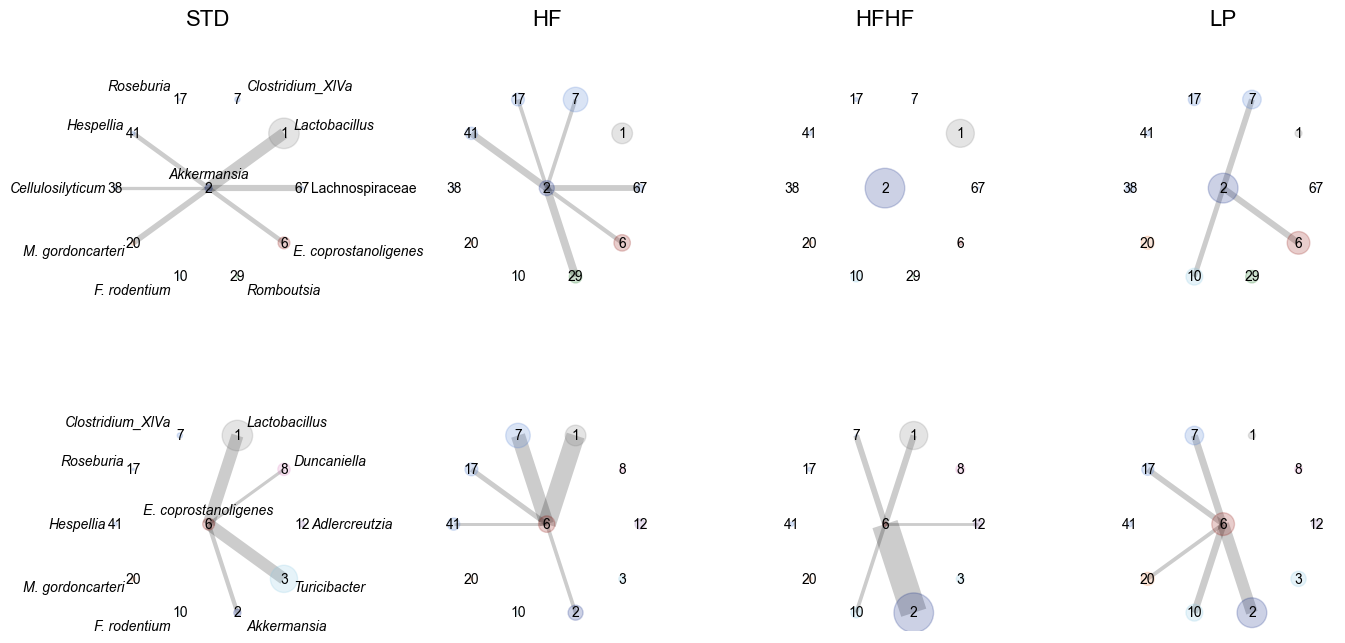

In [45]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

for row_idx in range(len(taxa_foci)):
    otuf = taxa_foci[row_idx]
    _,_=plot_association_changes(axs[row_idx,:], edge_weights[otuf], node_weights[otuf], otuf, taxonomy, 
                                        node_colors=pcolors[otuf], edge_scale=200, node_scale=2000, rad=1.2,
                                       edge_threshold = 0.01, edge_base=0, textsize=10)
    diets = edge_weights[otuf].columns
    for ax, diet in zip(axs[row_idx,:], diets):
        ax.set_aspect('equal', 'box')
        ax=vis.remove_border(ax)
        
        if row_idx == 0:
            ax.set_title(diet, pad=40, fontsize=16)

plt.subplots_adjust(wspace=0.5)
    
plt.savefig(outpath / "association_changes.pdf", bbox_inches="tight")
plt.savefig(outpath / "association_changes.png", bbox_inches="tight")

## figure out legend

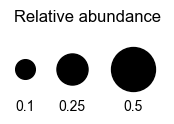

In [42]:
fig, ax = plt.subplots(figsize=(2,1))
ab = [0.1, 0.25, 0.5]
xp = np.array([-0.08, -0.02, 0.06])
for x,s in zip(xp,ab):
    ax.scatter(x,0,s=s*2000, c='black')
    ax.text(x,-0.05, s=f'{s}', verticalalignment='center', horizontalalignment='center')
ax.set_ylim(-0.05,0.05)
ax.set_xlim(-0.1,0.1)
ax.set_aspect('equal', 'box')
ax.set_title("Relative abundance")
ax=vis.remove_border(ax)

# save and manually add with illustrator

### line thickness...

In [17]:
node_weights['Otu2']

,STD,HF,HFHF,LP
Otu,,,,
Otu15,0.006535,0.017412,0.060776,0.012782
Otu12,0.008222,0.025964,0.018783,0.021430
Otu67,0.002308,0.014471,0.001184,0.001008
Otu1,0.240700,0.110752,0.202902,0.012623
Otu7,0.006949,0.155743,0.000924,0.089202
Otu17,0.001178,0.042695,0.003755,0.037520
Otu41,0.003254,0.039001,0.004629,0.006763
Otu38,0.003037,0.002256,0.000416,0.019459
Otu20,0.005345,0.002962,0.005396,0.044075


# to do :
- legend components: colormap, edge width, circle size, ...tax naming?
- clean up further -> only include taxa that have an edge on some diet

### is there a directionality?; is it weird that akkermansia associates on hfhf in bottom but not top???; because of normalization...; think about this though...

In [18]:
edge_weights['Otu6']

Time,STD,HF,HFHF,LP
Otu,,,,
Otu24,0.002517,0.000537,0.000914,0.000296
Otu90,0.002103,0.006937,0.001643,0.001636
Otu12,0.003607,0.004388,0.010232,0.003643
Otu58,0.001585,0.000142,0.000507,0.000203
Otu8,0.011290,0.000673,0.003369,0.000390
Otu1,0.044144,0.066481,0.023101,0.001198
Otu7,0.006426,0.051358,0.021168,0.025421
Otu26,0.003235,0.005710,0.002274,0.002202
Otu17,0.003027,0.018166,0.009823,0.020235


In [19]:
edge_weights['Otu2']

Time,STD,HF,HFHF,LP
Otu,,,,
Otu15,0.001697,0.002528,0.000569,0.004563
Otu12,0.005437,0.004504,0.000553,0.004773
Otu67,0.022129,0.020974,0.000158,0.000729
Otu1,0.041778,0.005932,0.000938,0.000971
Otu7,0.008714,0.013723,0.002004,0.021429
Otu17,0.006120,0.013490,0.000323,0.006740
Otu41,0.016602,0.025088,0.000560,0.002206
Otu38,0.011814,0.003949,0.000392,0.008756
Otu20,0.021070,0.002414,0.000549,0.009504


In [20]:
taxonomy.loc['Otu20',:]

Domain                      Bacteria
Phylum                 Bacteroidetes
Class                    Bacteroidia
Order                  Bacteroidales
Family                            na
Genus                             na
Species    Muribaculum gordoncarteri
Name: Otu20, dtype: object

### fix taxonomy in data